# AI in image Processing
### Sameera Holy SHEIK ABDULLAH

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###  Importing Libraries


In [73]:
import re
import cv2
import glob
import random as rd
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
%matplotlib inline

In [7]:
train = glob.glob("drive/MyDrive/EPITA/CV/Chess Position/train/*.jpeg")
test = glob.glob("drive/MyDrive/EPITA/CV/Chess Position/test/*.jpeg")

piece_symbols = 'prbnkqPRBNKQ'

In [10]:
train_size = len(train)
test_size = len(test)

- Define a function to extract labels/FEN from Images

In [11]:
# Get the labels ( FNE ) for the training and testing images
def get_image_FEN_label(image_path):
    fen_label= image_path.replace('.jpeg', '').split('/')[-1]
    return fen_label

- Display a random sample of the data

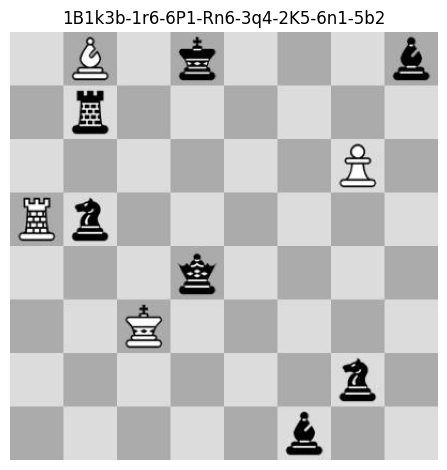

In [84]:
img_path =train[0]
img_moves =  get_image_FEN_label(img_path)
img_rand=cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(img_moves)
plt.axis('off')
plt.tight_layout()
plt.show()

- Check the Python Chess Library to understand the FEN format

In [13]:
! pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00


The FEN notation of the image is:  1B2KQ2-3N4-8-7r-7k-8-n7-4b3


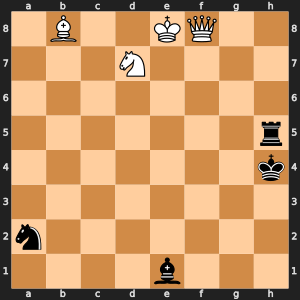

In [14]:
import chess.svg
import chess
print("The FEN notation of the image is: ", img_moves)
board = chess.Board(img_moves.replace('-', '/'))
chess.svg.board(board, size=300)


# Data Augmentation

In [16]:
def preprocess_some_images(img_paths, width, height):
  resized_imgs = []
  for img_path in img_paths:
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(img, (width, height))
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    resized_imgs.append(gray_image)

  return resized_imgs

In [17]:
preprocessed_imgs = preprocess_some_images(train,240,240)

# PCA

Images are high-dimensional data. Each pixel in an image represents a feature, and for high-resolution images, the number of features can be very large. PCA can help reduce this high dimensionality by identifying the principal components that capture the most significant variations in the data.

In [21]:
from sklearn.decomposition import PCA

In [35]:
def apply_pca(image, n_components=10):
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(image)

    return transformed, pca

Take a sample and apply PCA on the image

In [36]:
img = np.array(cv2.imread(train[0]))
new_img=img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))
new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)

In [54]:
transformed, pca = apply_pca(new_img, 20)

The dimensionality is reduced with the same feature representation with the below 2 images

Text(0.5, 1.0, 'After PCA image')

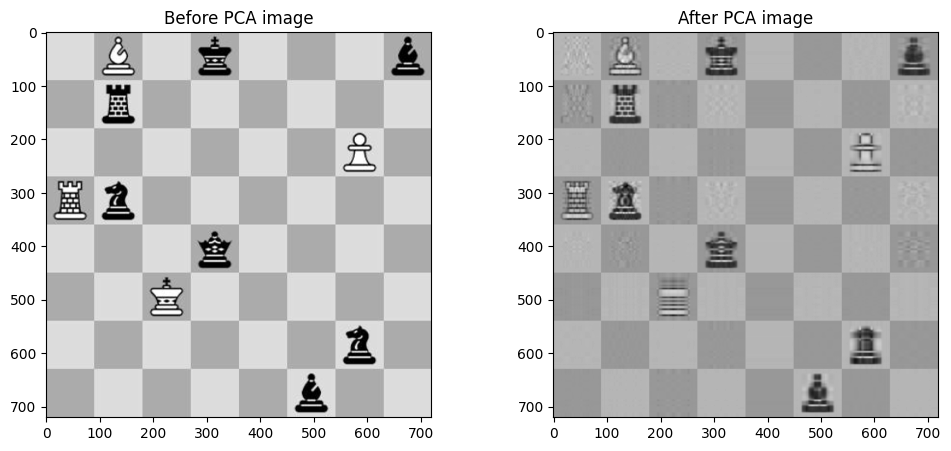

<Figure size 600x600 with 0 Axes>

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
img = np.array(cv2.imread(train[0]))
new_img=img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))
new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)
ax1.imshow(new_img, cmap='gray')
ax1.set_title("Before PCA image")

plt.figure(figsize=(6, 6))
temp = pca.inverse_transform(transformed)
temp = np.reshape(temp, (720,720))
ax2.imshow(temp, cmap='gray')
ax2.set_title("After PCA image")

#Feature Engineering

Each image is converted into square representing each cell in the chess board

In [62]:
def image_to_squares(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
  return np.array(squares)

Now PCA is applied on each squares

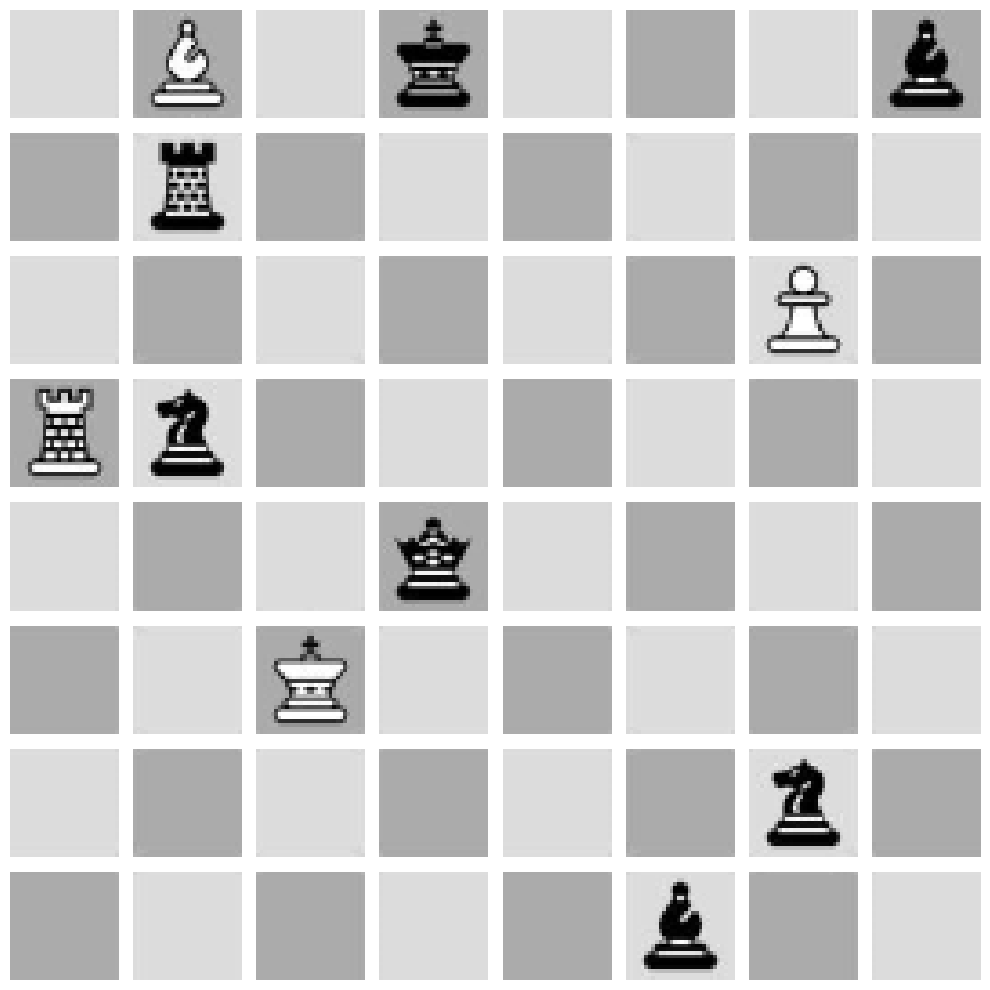

(64, 30, 30, 3)

In [63]:
sqaures= image_to_squares(preprocessed_imgs[0],240,240)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- Create a function to the complete preprocessing and sqaures division of one sample of the data

In [64]:
def preprocess_image(img_path):
    height =240
    width =240

    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

    gray_image = cv2.resize(img, (width, height))

    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    squares = image_to_squares(gray_image,height,width)
    return squares

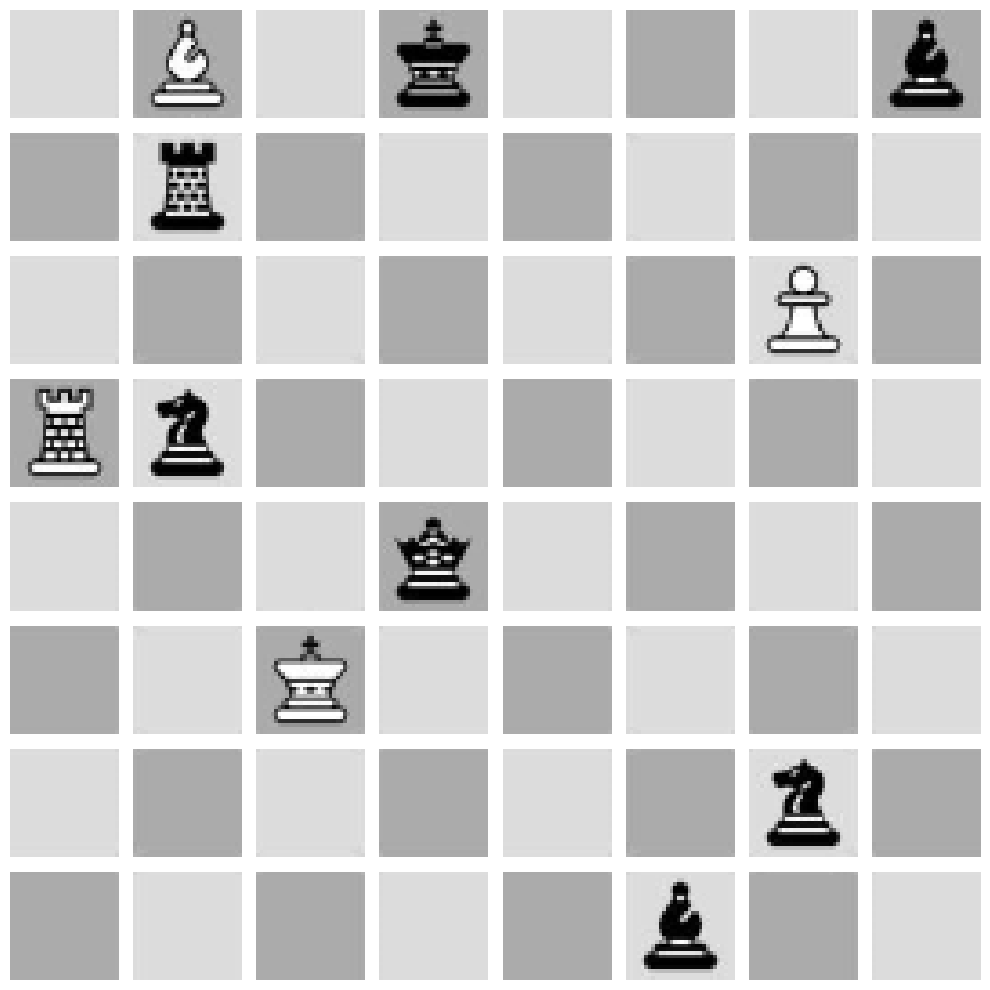

(64, 30, 30, 3)

In [65]:
sqaures=preprocess_image(train[0])

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

In [66]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

- Create a function divide the data into training and testing sets

In [67]:
def train_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

# CNN

In [68]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, (3, 3),activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(32, (5, 5),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          12816     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 13)                5213      
                                                        

In [69]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
EPOCHS=100

hist = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(test), validation_steps=test_size//EPOCHS)


Training Progress:
------------------------
Epoch 1/100
9/9 [==============================] - 2s 126ms/step - loss: 1.8889 - accuracy: 0.5972
Epoch 2/100
9/9 [==============================] - 1s 80ms/step - loss: 1.1481 - accuracy: 0.8021
Epoch 3/100
9/9 [==============================] - 1s 79ms/step - loss: 1.0609 - accuracy: 0.8021
Epoch 4/100
9/9 [==============================] - 1s 92ms/step - loss: 0.9503 - accuracy: 0.8385
Epoch 5/100
9/9 [==============================] - 1s 99ms/step - loss: 0.8785 - accuracy: 0.8177
Epoch 6/100
9/9 [==============================] - 1s 135ms/step - loss: 0.9131 - accuracy: 0.8108
Epoch 7/100
9/9 [==============================] - 1s 131ms/step - loss: 0.6643 - accuracy: 0.8368
Epoch 8/100
9/9 [==============================] - 1s 142ms/step - loss: 0.8124 - accuracy: 0.7830
Epoch 9/100
9/9 [==============================] - 1s 128ms/step - loss: 0.6978 - accuracy: 0.8333
Epoch 10/100
9/9 [==============================] - 1s 77ms/step - l

## Prediction

In [76]:
res = (
  model.predict_generator(pred_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [92]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Accuracy: ",round(final_accuracy, 2))

Accuracy:  0.57


In [94]:
print("Confusion Matrix:")
confusion_matrix(test_fens, pred_fens)

Confusion Matrix:


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [79]:
print("Precison:", precision_score(test_fens, pred_fens, average='weighted'))
print("Recall:", recall_score(test_fens, pred_fens, average='weighted'))
print("F1 Score:", f1_score(test_fens, pred_fens, average='weighted'))
print("Accuracy:", accuracy_score(test_fens, pred_fens))

Precison: 0.5729166666666666
Recall: 0.5729166666666666
F1 Score: 0.5729166666666666
Accuracy: 0.5729166666666666


Reference: https://www.kaggle.com/code/ananyaroy1011/chess-positions-fen-prediction-eda-cnn-model